# Epilepsy Detection with LSTMs — Training Notebook
*Generated: 2025-09-04 06:17:31*

This notebook trains a 2-layer LSTM to classify EEG segments as **epileptic (1)** vs **non-epileptic (0)**  
using the UCI *Epileptic Seizure Recognition* dataset (`/mnt/data/data.csv`).

**Pipeline**
1. Load & clean data  
2. Convert 5-class labels to binary (`1` → epileptic, else `0`)  
3. (Optional) Subsample every 4th row as described  
4. Normalize features (StandardScaler)  
5. Reshape to sequences of length 178 with 1 feature per timestep  
6. Train 2-layer LSTM (Adam + Binary Crossentropy), 50 epochs with early stopping  
7. Save model & scaler, and plot training curves

## 0. Setup

In [52]:
# If running locally, ensure you have these installed:
# !pip install numpy pandas scikit-learn matplotlib tensorflow==2.* joblib

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

DATA_PATH = "/mnt/data/data.csv"   # Change if needed
MODEL_DIR = "/mnt/data/models"
MODEL_PATH = os.path.join(MODEL_DIR, "epilepsy_lstm.keras")
SCALER_PATH = os.path.join(MODEL_DIR, "scaler.joblib")

os.makedirs(MODEL_DIR, exist_ok=True)

print(tf.__version__)

2.16.1


## 1. Load data

In [54]:
# Load CSV (expects 178 feature columns + label column 'y' or last column)
# df = pd.read_csv('data.csv')
df = pd.read_csv('new_eeg_normal.csv')

# Drop obvious unnamed index columns if present
for col in list(df.columns):
    if 'unnamed' in col.lower():
        df = df.drop(columns=[col])

print("Shape after load:", df.shape)
print("Columns:", df.columns[:10], "...")
df.head()

Shape after load: (0, 178)
Columns: Index(['-86', '-101', '-115', '-129', '-139', '-147', '-154', '-159', '-165',
       '-170'],
      dtype='object') ...


,-86,-101,-115,-129,-139,-147,-154,-159,-165,-170,...,-33,-39,-43,-44.2,-45.1,-39.1,-38,-35,-34,-36


## 2. Prepare features and labels

In [55]:
# Try to locate label column
label_col = 'y' if 'y' in df.columns else df.columns[-1]

X = df.drop(columns=[label_col]).values
y_raw = df[label_col].values

# Convert to binary: 1 -> 1 (epileptic), {2,3,4,5} -> 0 (non-epileptic)
y = (y_raw == 1).astype(int)

print("Feature shape:", X.shape, "Label shape:", y.shape)
print("Class distribution (binary):", {0: int((y==0).sum()), 1: int((y==1).sum())})

Feature shape: (0, 177) Label shape: (0,)
Class distribution (binary): {0: 0, 1: 0}


## 3. Optional: take 1 in every 4 samples (subsampling)

In [56]:
TAKE_EVERY_4TH = True  # Set False to use full dataset

if TAKE_EVERY_4TH:
    X = X[::4]
    y = y[::4]
    print("After subsampling every 4th row ->", X.shape, y.shape)

After subsampling every 4th row -> (0, 177) (0,)


## 4. Train/Validation split

In [57]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Val:", X_val.shape)

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

## 5. Normalize (StandardScaler)

In [58]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


MODEL_DIR = "./models"
os.makedirs(MODEL_DIR, exist_ok=True)

SCALER_PATH = os.path.join(MODEL_DIR, "scaler2.joblib")

# Save scaler for use in the inference notebook
joblib.dump(scaler, SCALER_PATH)
print("Scaler saved to:", SCALER_PATH)



Scaler saved to: ./models\scaler2.joblib


## 6. Reshape to sequences for LSTM
We treat each sample as a sequence of length 178 with 1 feature per timestep.

In [59]:
def to_sequences(arr_2d):
    # arr_2d: (n_samples, 178) -> (n_samples, 178, 1)
    return arr_2d.reshape(arr_2d.shape[0], arr_2d.shape[1], 1)

X_train_seq = to_sequences(X_train_scaled)
X_val_seq   = to_sequences(X_val_scaled)

print("X_train_seq shape:", X_train_seq.shape)
print("X_val_seq shape:", X_val_seq.shape)

X_train_seq shape: (2300, 178, 1)
X_val_seq shape: (575, 178, 1)


## 7. Build 2-layer LSTM model

In [60]:
tf.keras.utils.set_random_seed(42)

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\Dell\Videos\Clg Project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 178, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 178, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

## 8. Train (50 epochs) with EarlyStopping & ModelCheckpoint

In [61]:

MODEL_DIR = "./models"
MODEL_PATH = os.path.join(MODEL_DIR, "epilepsy_lstm2.keras")

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ModelCheckpoint(MODEL_PATH, monitor='val_loss', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("Best model saved to:",MODEL_PATH )

Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.8173 - loss: 0.5396
Epoch 1: val_loss improved from None to 0.14773, saving model to ./models\epilepsy_lstm2.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 453ms/step - accuracy: 0.8839 - loss: 0.3755 - val_accuracy: 0.9583 - val_loss: 0.1477
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9507 - loss: 0.1499
Epoch 2: val_loss improved from 0.14773 to 0.10849, saving model to ./models\epilepsy_lstm2.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 14s 344ms/step - accuracy: 0.9478 - loss: 0.1439 - val_accuracy: 0.9652 - val_loss: 0.1085
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9644 - loss: 0.1152
Epoch 3: val_loss did not improve from 0.10849
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 327ms/step - accuracy: 0.9639 - loss: 0.1287 - val_accuracy: 0.9409 - val_loss: 0.2041
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9359 - loss: 0.2147
Epoch 4: val_loss did not improve from 0.10849
36/36 ━━━━━━━━━

## 9. Plot training history

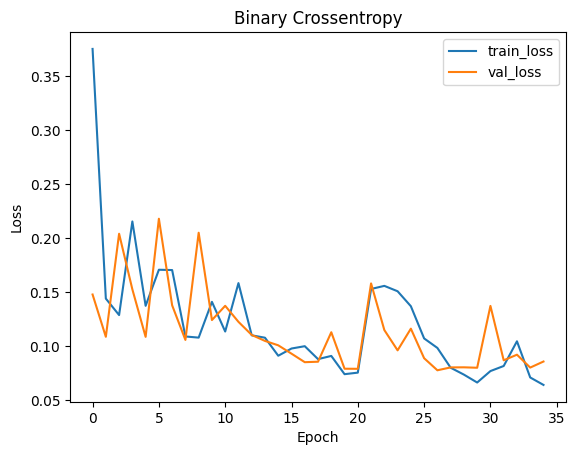

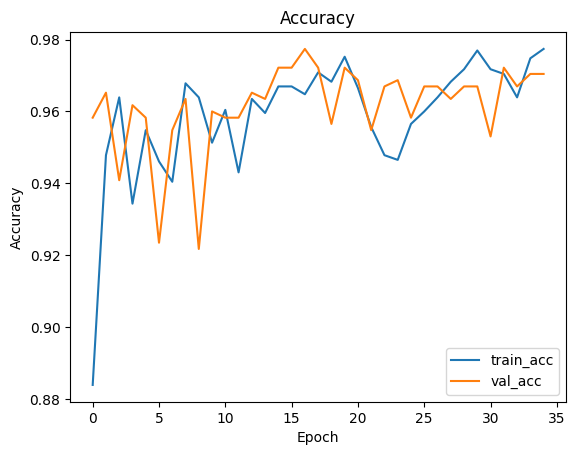

In [62]:
# Plot Loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Binary Crossentropy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 10. Quick validation metrics (AUC & report)

In [63]:
val_pred_prob = model.predict(X_val_seq).ravel()
val_pred_bin = (val_pred_prob >= 0.5).astype(int)

auc = roc_auc_score(y_val, val_pred_prob)
print("Validation ROC AUC:", round(auc, 4))

print("\nClassification report (val):")
print(classification_report(y_val, val_pred_bin, digits=4))

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step
Validation ROC AUC: 0.9934

Classification report (val):
              precision    recall  f1-score   support

           0     0.9846    0.9740    0.9793       461
           1     0.8992    0.9386    0.9185       114

    accuracy                         0.9670       575
   macro avg     0.9419    0.9563    0.9489       575
weighted avg     0.9677    0.9670    0.9672       575

